# risk parity portfolio

- 配当込みリターンの計算
- 配当込み時系列を使ったリスクパリティポートフォリオの構築

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

figsize = (11, 5)

In [46]:
ticker_list = ['VTI', 'VGK', 'VPL', 'VWO', '2510.T', '2511.T', '2519.T', '2844.T', 'A35.SI', 'GLD', 'BBRE', 'IFGL']
tickers = yf.Tickers(ticker_list)
df = tickers.history(period='max')
df.rename(columns={'Stock Splits': 'Stock_Splits'}, inplace=True)
df.dropna(subset=[('Close', ticker) for ticker in ticker_list], inplace=True)
df.index = df.index.strftime('%Y-%m-%d')

[*********************100%***********************]  12 of 12 completed


In [47]:
capital_gains = df['Capital Gains']
close = df['Close']

## 累積リターン

In [48]:
for ticker in ticker_list:
    # 対数日次リターン
    df.loc[:, ('log_return', f'{ticker}')] = np.log(df.loc[:, ('Close', f'{ticker}')]).diff()
    # 初日を0にする
    df.loc[df.index[0], ('log_return', f'{ticker}')] = 0
    # 対数累積リターン
    df.loc[:, ('cum_log_return', f'{ticker}')] = df.loc[:, ('log_return', f'{ticker}')].cumsum()
    # 指数化
    df.loc[:, ('cum_return', f'{ticker}')] = np.exp(df.loc[:, ('cum_log_return', f'{ticker}')]) - 1

## 配当込みリターン

1. 配当利回り

   配当金 ÷ 終値

2. 対数日次リターン + 配当利回り

3. 累積リターン

   対数日次リターン + 配当利回り の累積

In [49]:
# 配当利回りを計算する．
for ticker in ticker_list:
    # 配当金
    dividend = df.loc[:, ('Dividends', f'{ticker}')].astype(float)
    # 終値
    close = df.loc[:, ('Close', f'{ticker}')].astype(float)
    # 配当利回り
    df.loc[:, ('dividend_yield', f'{ticker}')] = dividend / close

/tmp/ipykernel_2920/1930040640.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, ('dividend_yield', f'{ticker}')] = dividend / close
/tmp/ipykernel_2920/1930040640.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, ('dividend_yield', f'{ticker}')] = dividend / close
/tmp/ipykernel_2920/1930040640.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

In [50]:
# 配当利回りを考慮したリターンを計算する．
for ticker in ticker_list:
    # 代入 (配当利回り，対数日次リターン)
    dividend_yield = df.loc[:, ('dividend_yield', f'{ticker}')].astype(float)
    log_return = df.loc[:, ('log_return', f'{ticker}')]

    # 配当利回りを考慮した対数日次リターン
    df.loc[:, ('log_return_div_included', f'{ticker}')] =  dividend_yield + log_return

    # 配当利回りを考慮した対数累積リターン
    df.loc[:, ('cum_log_return_div_included', f'{ticker}')] = df.loc[:, ('log_return_div_included', f'{ticker}')].cumsum()

    # 指数化
    df.loc[:, ('cum_return_div_included', f'{ticker}')] = np.exp(df.loc[:, ('cum_log_return_div_included', f'{ticker}')]) - 1

/tmp/ipykernel_2920/567186777.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, ('log_return_div_included', f'{ticker}')] =  dividend_yield + log_return
/tmp/ipykernel_2920/567186777.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[:, ('cum_log_return_div_included', f'{ticker}')] = df.loc[:, ('log_return_div_included', f'{ticker}')].cumsum()
/tmp/ipykernel_2920/567186777.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Text(0.5, 1.0, 'Cumulative Return (Dividend Included)')

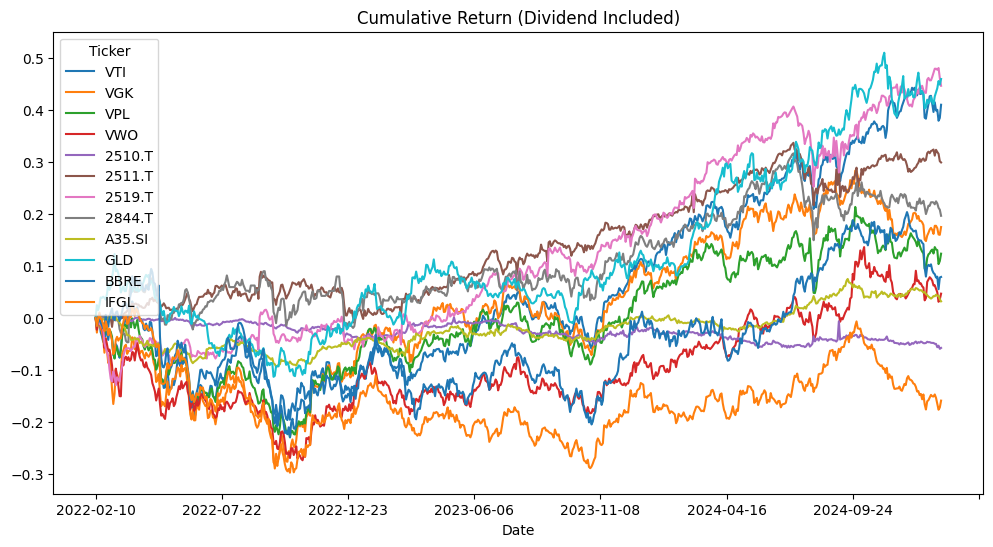

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))

df['cum_return_div_included'].plot(ax=ax)
ax.set_title('Cumulative Return (Dividend Included)')

In [23]:
def get_sd(data, ticker):
    std = np.std(data.log_return_div_included[ticker])
    std_annual = std * np.sqrt(252) # 年率化
    return std_annual

for ticker in ticker_list:
    print(f'{ticker} sd: {get_sd(df, ticker):.3%}')


VTI sd: 18.301%
VGK sd: 19.941%
VPL sd: 17.098%
VWO sd: 18.728%
2510.T sd: 5.292%
2511.T sd: 11.816%
2519.T sd: 14.279%
2844.T sd: 15.009%
A35.SI sd: 5.890%
GLD sd: 15.178%
BBRE sd: 21.562%
IFGL sd: 18.558%
IGF sd: 15.674%
WOOD sd: 20.560%


In [24]:
def get_weight(data, ticker_list):
    inv_sd_dict = {}
    for ticker in ticker_list:
        inv_sd = 1 / get_sd(data, ticker)
        inv_sd_dict[ticker] = inv_sd
    sum_inv_sd = sum(inv_sd_dict.values())
    weight_dict = {ticker: inv_sd / sum_inv_sd for ticker, inv_sd in inv_sd_dict.items()}
    return weight_dict

weights = get_weight(df, ticker_list)

for ticker, weight in weights.items():
    print(f'{ticker} weight: {weight:.3%}')

VTI weight: 5.082%
VGK weight: 4.664%
VPL weight: 5.439%
VWO weight: 4.966%
2510.T weight: 17.574%
2511.T weight: 7.870%
2519.T weight: 6.513%
2844.T weight: 6.196%
A35.SI weight: 15.790%
GLD weight: 6.127%
BBRE weight: 4.313%
IFGL weight: 5.011%
IGF weight: 5.933%
WOOD weight: 4.523%


In [25]:
# ポートフォリオのボラティリティ
weights = get_weight(df, ticker_list)
sd_list = [get_sd(df, ticker) for ticker in ticker_list]

weight_sd = sd_list @ np.array(list(weights.values()))

print(f'Portfolio sd: {weight_sd:.3%}')

Portfolio sd: 13.019%


In [26]:
# ポートフォリオのボラティリティ
weights = get_weight(df, ticker_list)
sd_list = [get_sd(df, ticker) for ticker in ticker_list]

# 標準偏差のベクトルを作成
weights_array = np.array(list(weights.values()))
sd_array = np.array(sd_list)

# 共分散行列を取得
cov_matrix = df.log_return_div_included[ticker_list].cov().values

# ポートフォリオのボラティリティを計算
portfolio_volatility = np.sqrt(weights_array.T @ cov_matrix @ weights_array)
portfolio_volatility_annual = portfolio_volatility * np.sqrt(252)
print(f'Portfolio sd: {portfolio_volatility_annual:.3%}')

Portfolio sd: 7.818%


In [27]:
total_asset = 130
for ticker in ticker_list:
    asset_dict = {}
    asset_dict = {ticker: total_asset * weight for ticker, weight in weights.items()}

print(f'Total asset: {total_asset} 万円')
for ticker, asset in asset_dict.items():
    print(f'{ticker} asset: {asset:.3f} 万円')

Total asset: 130 万円
VTI asset: 6.606 万円
VGK asset: 6.063 万円
VPL asset: 7.071 万円
VWO asset: 6.455 万円
2510.T asset: 22.846 万円
2511.T asset: 10.231 万円
2519.T asset: 8.466 万円
2844.T asset: 8.055 万円
A35.SI asset: 20.527 万円
GLD asset: 7.965 万円
BBRE asset: 5.607 万円
IFGL asset: 6.515 万円
IGF asset: 7.713 万円
WOOD asset: 5.880 万円


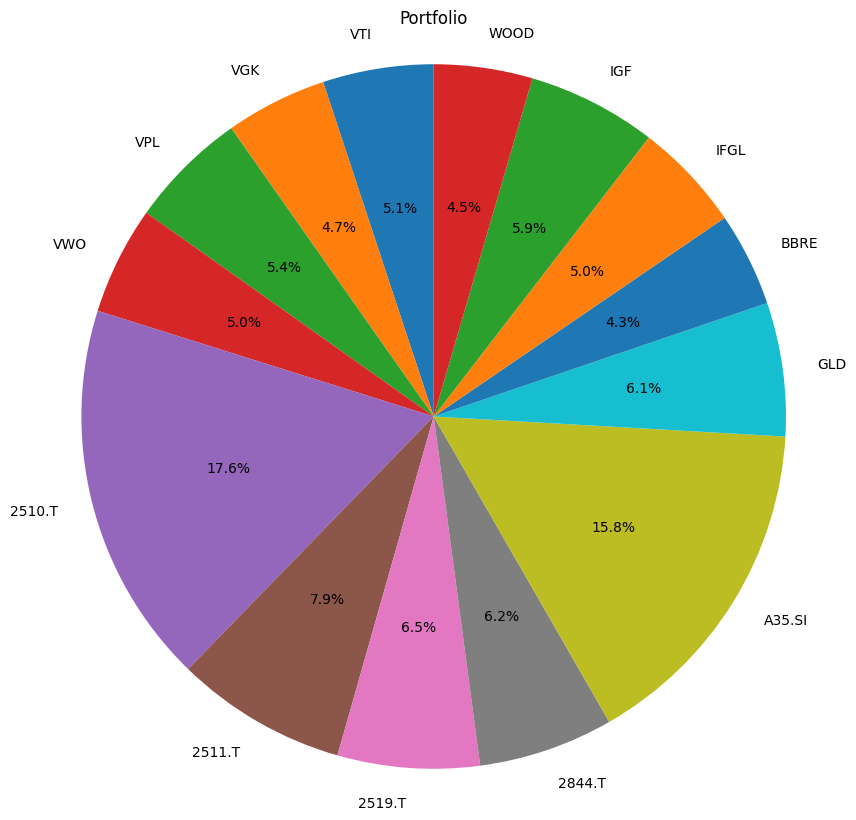

In [28]:
labels = list(asset_dict.keys())
sizes = list(asset_dict.values())

fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.axis('equal')
ax.set_title('Portfolio')
plt.show()

## 分散共分散行列

In [29]:
cov_matrix = df.log_return_div_included[ticker_list].cov().values
risk = np.sqrt(cov_matrix.sum().sum())
print(f'Risk: {risk:.3%}')

Risk: 9.189%
